In [43]:
import numpy as np
import os
import os.path
import src.visualization.display as dsp
import netCDF4 as nc
import matplotlib.pyplot as plt
import torch
from pytorch_lightning import Trainer,seed_everything,LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import src.unet as unet
import scipy.ndimage.morphology as scm
import importlib
import matplotlib.ticker as mtick
importlib.reload(dsp)

<module 'src.visualization.display' from '/Users/skrunes/Documents/DL-normalization/src/visualization/display.py'>

In [45]:
os.getcwd()
os.chdir("DL-normalization/")
os.getcwd()

'/Users/skrunes/Documents/DL-normalization'

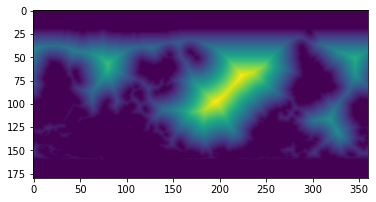

In [46]:
with nc.Dataset("data/water_ratio.nc" , 'r') as data:
    water_ratio = data['water_ratio_1_1'][:]

mask = water_ratio<=0.02
mask[:20,:] = 1
mask[-20:,:]=1

pad = 40
mask_pad = np.empty((180,360 + 2*pad),dtype=bool)
mask_pad[:,pad:-pad] = mask
mask_pad[:,:pad] = np.copy(mask_pad[:,-2*pad:-pad])
mask_pad[:,-pad:] = np.copy(mask_pad[:,pad:2*pad])


dst_pad = scm.distance_transform_bf(~mask_pad)
dst=dst_pad[:,pad:-pad]
plt.imshow(dst)

In [47]:
model = unet.Unet.load_from_checkpoint("results/wandb/learning_curve/9uqpnr1k/checkpoints/epoch=442-val_loss=0.00010.ckpt")
X=np.load("data/processed/isotropic_noise100_samples_standardize/valid/X/sphere_polecontinent106.npz")['arr_0']
X=torch.from_numpy(X[np.newaxis,:]).float()
print(X.shape)
X = X[:,:,10:-10,12:-12]
#X=X
Y=np.load("data/processed/isotropic_noise100_samples_standardize/valid/Y/sphere_polecontinent106_norm_coeffs.npz")['arr_0']
mask = np.where(Y[10:-10,:]==0,True,False)
Y = Y[10:-10,:]*model.norm_std + model.norm_mean
Y_pred = model.forward(X).detach().numpy()[0,0,:,28:-28]*model.norm_std + model.norm_mean
#mask = np.where(Y==0,True,False)
eps = (Y_pred**2 - Y**2)/Y**2
eps = np.ma.masked_array(eps, mask)

torch.Size([1, 3, 180, 448])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 53 but got size 52 for tensor number 1 in the list.

In [65]:
model = unet.Unet.load_from_checkpoint("results/wandb/learning_curve/29fyzcrb/checkpoints/epoch=924-val_loss=0.00008.ckpt")
X=np.load("data/processed/isotropic_noise100_samples_standardize/valid/X/sphere_polecontinent106.npz")['arr_0']
X=torch.from_numpy(X[np.newaxis,:]).float()
print(X.shape)
X = X[:,:,10:-10,:]

#plt.imshow(X[0,0,:,:])

#X=X
Y=np.load("data/processed/isotropic_noise100_samples_standardize/valid/Y/sphere_polecontinent106_norm_coeffs.npz")['arr_0']
mask = np.where(Y[10:-10,:]==0,True,False)
Y = Y[10:-10,:]*model.norm_std + model.norm_mean
Y_pred = model.forward(X).detach().numpy()[0,0,:,44:-44]*model.norm_std + model.norm_mean
#mask = np.where(Y==0,True,False)
eps = (Y_pred**2 - Y**2)/Y**2
eps = np.ma.masked_array(eps, mask)
mse=((Y_pred - Y)**2)

torch.Size([1, 3, 180, 448])


In [60]:
dir_path="data/processed/isotropic_noise100_samples_standardize/valid/X/"
eps = np.empty((len(os.listdir(dir_path)),160,360))
for i,file_list in enumerate(os.listdir(dir_path)):
    X=np.load(dir_path+file_list)['arr_0']
    X=torch.from_numpy(X[np.newaxis,:]).float()
    X = X[:,:,10:-10,:]
    Y=np.load("data/processed/isotropic_noise100_samples_standardize/valid/Y/" + file_list.split(".")[0]+"_norm_coeffs.npz")['arr_0']
    if i==0:
        mask = np.where(Y[10:-10,:]==0,True,False) 
    Y = Y[10:-10,:]*model.norm_std + model.norm_mean
    Y_pred = model.forward(X).detach().numpy()[0,0,:,44:-44]*model.norm_std + model.norm_mean
    aux = (Y_pred - Y)**2
    eps[0,:,:] = np.ma.masked_array(aux, mask)

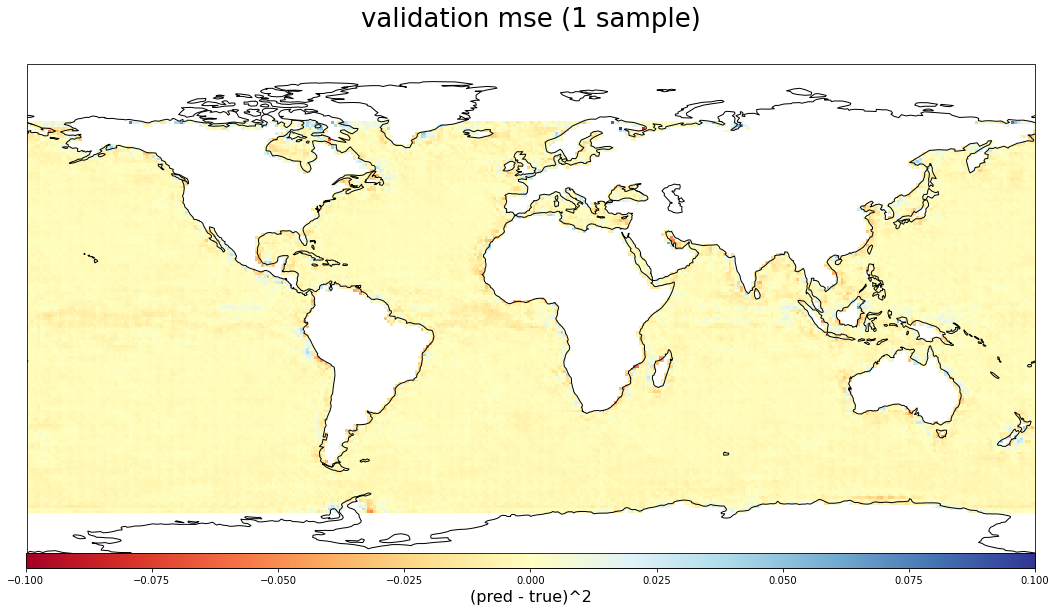

mean:  0.004254698898419488
max:  0.12905754252183643


In [66]:
lon = np.arange(-180, 180)
lat = np.arange(-80, 80)
lon2d, lat2d = np.meshgrid(lon, lat)
dsp.plot_error_globe(eps[:,:], lon2d, lat2d,vmin=-0.1,vmax=0.1,cmap="RdYlBu",
                     cmap_title="(pred - true)^2",title="validation mse (1 sample)")
print("mean: ",np.mean(np.abs(eps)))
print("max: ",np.max(np.abs(eps)))

In [70]:
#mask_rnd=torch.from_numpy(np.ma.getmask(eps_rnd[20:-20,:]))
eps_torch=torch.from_numpy(eps.flatten()).float()
mask_torch = torch.from_numpy(mask.flatten()).bool()
print(torch.quantile(torch.abs(eps_torch.flatten()[torch.flatten(~mask_torch)]),0.9999))

tensor(0.0778)


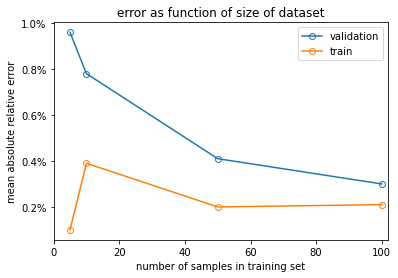

In [39]:
fig,ax = plt.subplots()
ns = [5,10,50,100]
val_error = [0.0096,0.0078,0.0041,0.003]
train_error = [0.001,0.0039,0.002,0.0021]
ax.plot(ns,val_error,"o-",markerfacecolor='none',label="validation",)
ax.plot(ns,train_error,"o-",markerfacecolor='none',label="train")
#ax.semilogy(ranges[:-1],means2,"o-",markerfacecolor='none',label="ronneberger")
#ax.semilogy(ranges[:-1],means3,"o-",markerfacecolor='none',label="pix2pix5 + 2x2conv normalised")
ax.set_xlim(0,102)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1, symbol='%', is_latex=False))
ax.set_ylabel("mean absolute relative error")
ax.set_xlabel("number of samples in training set")
ax.set_title("error as function of size of dataset")
ax.legend()


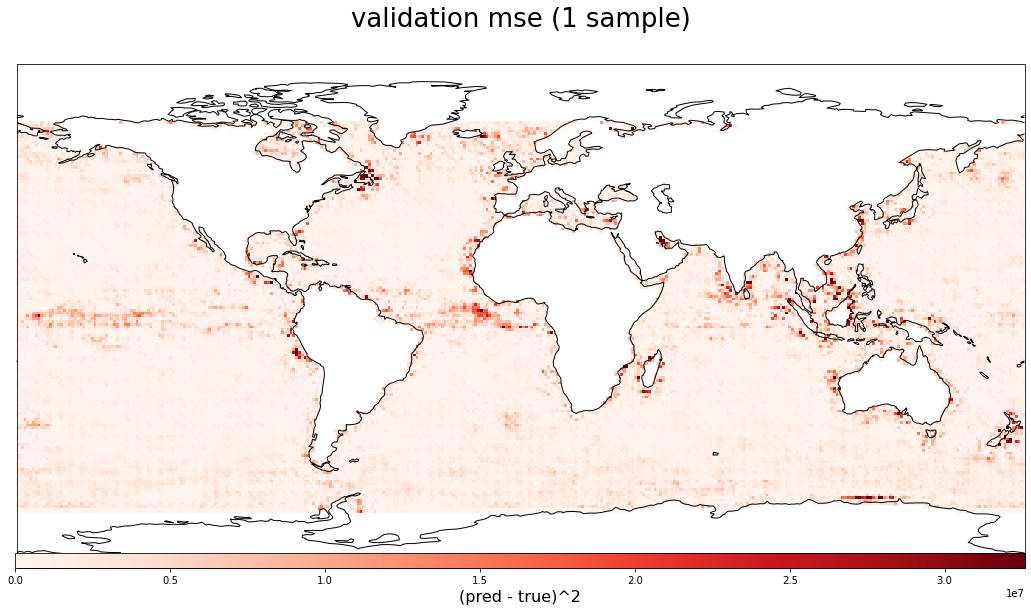

mean:  1599445.893527248
max:  92576913.29850906


In [27]:
importlib.reload(dsp)
lon = np.arange(-180, 180)
lat = np.arange(-80, 80)
lon2d, lat2d = np.meshgrid(lon, lat)
mse = np.ma.masked_array(mse, mask)
dsp.plot_error_globe(mse, lon2d, lat2d,vmin=0,vmax=32576913,cmap="Reds",
                     cmap_title="(pred - true)^2",title="validation mse (1 sample)")
print("mean: ",np.mean(np.abs(mse)))
print("max: ",np.max(np.abs(mse)))

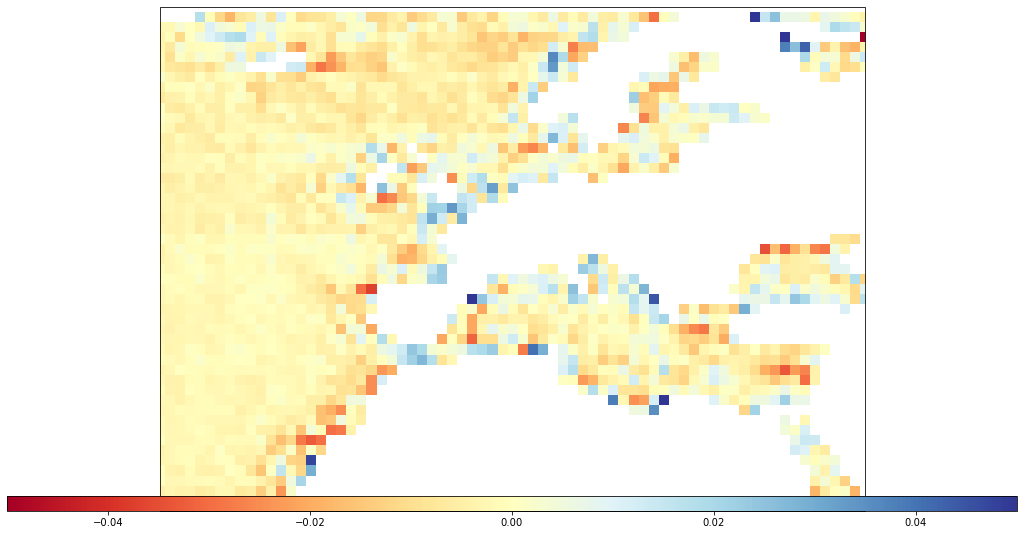

In [10]:
dsp.plot_error_region(np.ma.masked_array(eps, mask), 
                       lon2d, lat2d,region="europe",cmap="RdYlBu",vmin=-0.05,vmax=0.05)

In [28]:
model = unet.Unet.load_from_checkpoint("results/wandb/learning_curve/29fyzcrb/checkpoints/epoch=924-val_loss=0.00008.ckpt")
std = model.norm_std
mean = model.norm_mean
dir_path="data/processed/isotropic_noise100_samples_standardize/train/X/"
eps = np.empty((len(os.listdir(dir_path)),160,360))
for i,file_list in enumerate(os.listdir(dir_path)):
    X=np.load(dir_path+file_list)['arr_0']
    X=torch.from_numpy(X[np.newaxis,:]).float()
    X = X[:,:,10:-10,:]
    Y=np.load("data/processed/isotropic_noise100_samples_standardize/train/Y/" + file_list.split(".")[0]+"_norm_coeffs.npz")['arr_0']
    if i==0:
        mask = np.where(Y[10:-10,:]==0,True,False) 
    Y = Y[10:-10,:]*std + mean
    Y_pred = model.forward(X).detach().numpy()[0,0,:,44:-44]*std + mean
    aux = (Y_pred - Y)**2
    eps[i,:,:] = np.ma.masked_array(aux, mask)

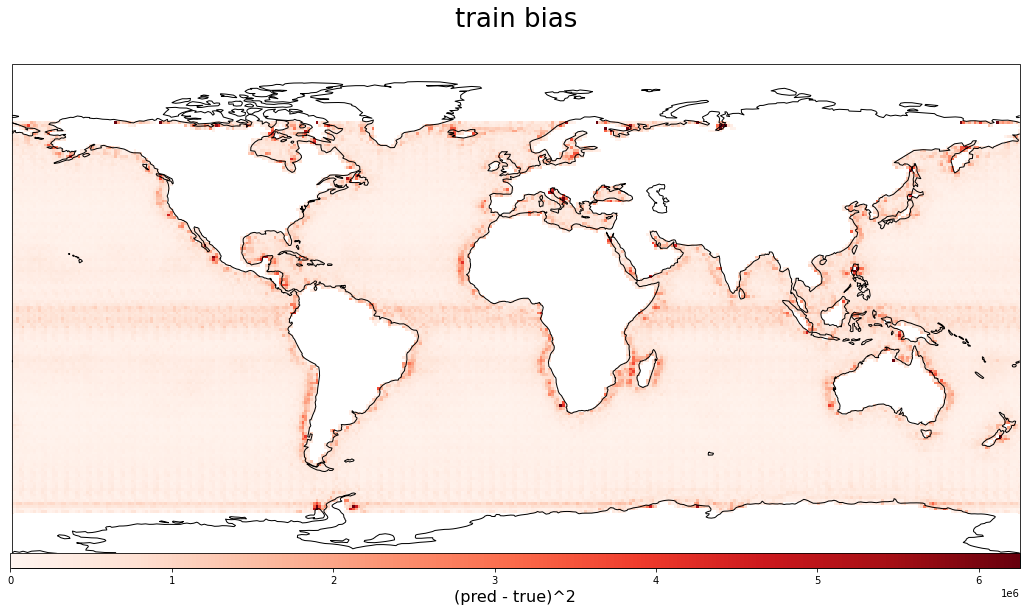

mean:  442357.062206
max:  30254880.60966526


In [38]:
importlib.reload(dsp)
lon = np.arange(-180, 180)
lat = np.arange(-80, 80)
lon2d, lat2d = np.meshgrid(lon, lat)
dsp.plot_error_globe(np.ma.masked_array(np.mean(eps,axis=0), mask), lon2d, lat2d,vmin=0,vmax=6254880,cmap="Reds",
                     cmap_title="(pred - true)^2",title="train bias")
print("mean: ",np.mean(np.abs(np.ma.masked_array(np.mean(eps,axis=0), mask))))
print("max: ",np.max(np.abs(np.ma.masked_array(np.mean(eps,axis=0), mask))))

In [94]:
print(mask[10:-10,:].flatten()[53723])

False


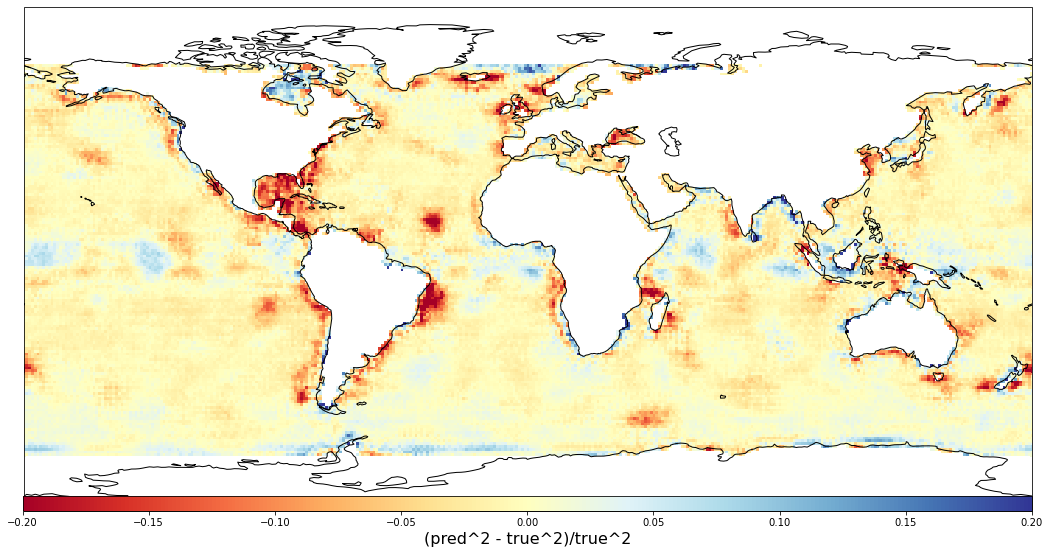

mean:  0.024965274764600677
max:  0.5253691613547476


In [366]:
importlib.reload(un)
model = un.Unet.load_from_checkpoint("wandb_learning_curve/learning_curve/3n7ot3jq/checkpoints/epoch=9051.ckpt")
X3=np.load("dataset/learning_curve_train4_valid3/valid/X/test_sphere_polecontinent3_normed_data.npz")['arr_0']
Y3=np.load("dataset/learning_curve_train4_valid3/valid/Y/test_sphere_polecontinent3_normed_data_norm.npz")['arr_0']
Y3 = Y3[10:-10,:]*109936.86714855532 + 524232.3493422137
X3=torch.from_numpy(X3[np.newaxis,:]).float()
X3 = X3[:,:,10:-10,12:-12]
#print(X4.shape,Y4.shape)
Y3_pred = model.forward(X3).detach().numpy()[0,0,:,28:-28]*109373.38313546701 + 523950.1477763484
mask = np.where(true_sphere==0,True,False)
diff3 = (Y3_pred**2 - Y3**2)/Y3**2
diff3 =np.ma.masked_array(diff3, mask)
dsp.plot_error_globe(diff3, lon2d, lat2d,vmin=-0.2,vmax=0.2,cmap="RdYlBu",
                     cmap_title="(pred^2 - true^2)/true^2")
print("mean: ",np.mean(np.abs(diff3)))
print("max: ",np.max(np.abs(diff3)))

In [159]:
for name, param in model.named_parameters():
    #if name == "pixmodel.1.weight":
    print(name)
    

pixmodel.0.model.model.0.weight
pixmodel.0.model.model.1.model.1.weight
pixmodel.0.model.model.1.model.2.weight
pixmodel.0.model.model.1.model.2.bias
pixmodel.0.model.model.1.model.3.model.1.weight
pixmodel.0.model.model.1.model.3.model.2.weight
pixmodel.0.model.model.1.model.3.model.2.bias
pixmodel.0.model.model.1.model.3.model.3.model.1.weight
pixmodel.0.model.model.1.model.3.model.3.model.2.weight
pixmodel.0.model.model.1.model.3.model.3.model.2.bias
pixmodel.0.model.model.1.model.3.model.3.model.3.model.1.weight
pixmodel.0.model.model.1.model.3.model.3.model.3.model.3.weight
pixmodel.0.model.model.1.model.3.model.3.model.3.model.4.weight
pixmodel.0.model.model.1.model.3.model.3.model.3.model.4.bias
pixmodel.0.model.model.1.model.3.model.3.model.5.weight
pixmodel.0.model.model.1.model.3.model.3.model.6.weight
pixmodel.0.model.model.1.model.3.model.3.model.6.bias
pixmodel.0.model.model.1.model.3.model.5.weight
pixmodel.0.model.model.1.model.3.model.6.weight
pixmodel.0.model.model.1.m

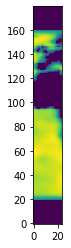

In [15]:
plt.imshow(np.concatenate((true_sphere[0,:,-12:],true_sphere[0,:,:12]),axis=1),origin="lower")

In [46]:
true_flat = torch.load("OF_data/UNET_flatpolecont3d4/true_10.pt").detach().numpy()[0,2:-2,:]
pred_flat = torch.load("OF_data/UNET_flatpolecont3d4/pred_8940.pt").detach().numpy()[0,0,:,:]

#true_flat = torch.load("OF_data/UNET_flat_polecontd4sample1_adam_bilinear/true_10.pt").detach().numpy()[0,2:-2,:]
#pred_flat = torch.load("OF_data/UNET_flat_polecontd4sample1_adam_bilinear/pred_5360.pt").detach().numpy()[0,0,:,:]

#true_flat = torch.load("OF_data/UNET_flat_polecontd4sample1_adamax_bilinear/true_10.pt").detach().numpy()[0,2:-2,:]
pred_flat2 = torch.load("OF_data/UNET_flat_polecontd4sample1_adamax_bilinear/pred_11450.pt").detach().numpy()[0,0,:,:]
#true_flat = torch.load("OF_data/UNET_polecontd4/true_10.pt").detach().numpy()[0,2:-2,:]
#pred_flat = torch.load("OF_data/UNET_polecontd4/pred_14680.pt").detach().numpy()[0,0,:,:]

#true_flat = torch.load("OF_data/UNET_flat_polecontsample1_adamax_bilinear_d3upconv/true_10.pt").detach().numpy()[0,2:-2,:]
pred_flat1 = torch.load("OF_data/UNET_flat_polecontsample1_adamax_bilinear_d3upconv/pred_14260.pt").detach().numpy()[0,0,:,:]
#pred_flat = torch.load("OF_data//pred_400.pt").detach().numpy()[0,0,:,:]


#true_flat = torch.load("OF_data/UNET_flat_continent/true_10.pt").detach().numpy()[0,6:-6,:]
#pred_flat = torch.load("OF_data/UNET_flat_continent/pred_990.pt").detach().numpy()[0,0,:,:]


#Y=torch.from_numpy(np.load("dataset/alpha_inv_test_pad/20/test_norms/id_151_norm.npz")['arr_0']).float()
#Y=np.load("dataset/alpha_inv_test_pad/20/test_norms/id_157_norm.npz")['arr_0']

#pred_flat3 = torch.load("OF_data/kraken_d4weighted/pred_9960.pt").detach().numpy()[0,2:-2,:]

In [225]:
print(true_flat.shape)
print(pred_flat3.shape)

(176, 360)
(176, 360)


/var/folders/rc/4xb0jqgx041dr7cpk4gsm8dm0000gp/T/ipykernel_7447/1296401038.py:5: RuntimeWarning: divide by zero encountered in true_divide
  eps = (pred_sphere**2-true_sphere**2)/true_sphere**2
/var/folders/rc/4xb0jqgx041dr7cpk4gsm8dm0000gp/T/ipykernel_7447/1296401038.py:6: RuntimeWarning: divide by zero encountered in true_divide
  eps1 = (pred_sphere1**2-true_sphere**2)/true_sphere**2
/var/folders/rc/4xb0jqgx041dr7cpk4gsm8dm0000gp/T/ipykernel_7447/1296401038.py:7: RuntimeWarning: divide by zero encountered in true_divide
  eps2 = (pred_sphere2**2-true_sphere**2)/true_sphere**2
/var/folders/rc/4xb0jqgx041dr7cpk4gsm8dm0000gp/T/ipykernel_7447/1296401038.py:8: RuntimeWarning: divide by zero encountered in true_divide
  eps3 = (pred_sphere3**2-true_sphere3**2)/true_sphere3**2
/var/folders/rc/4xb0jqgx041dr7cpk4gsm8dm0000gp/T/ipykernel_7447/1296401038.py:9: RuntimeWarning: divide by zero encountered in true_divide
  eps4 = (pred_sphere4**2-true_sphere**2)/true_sphere**2
/var/folders/rc/4xb0

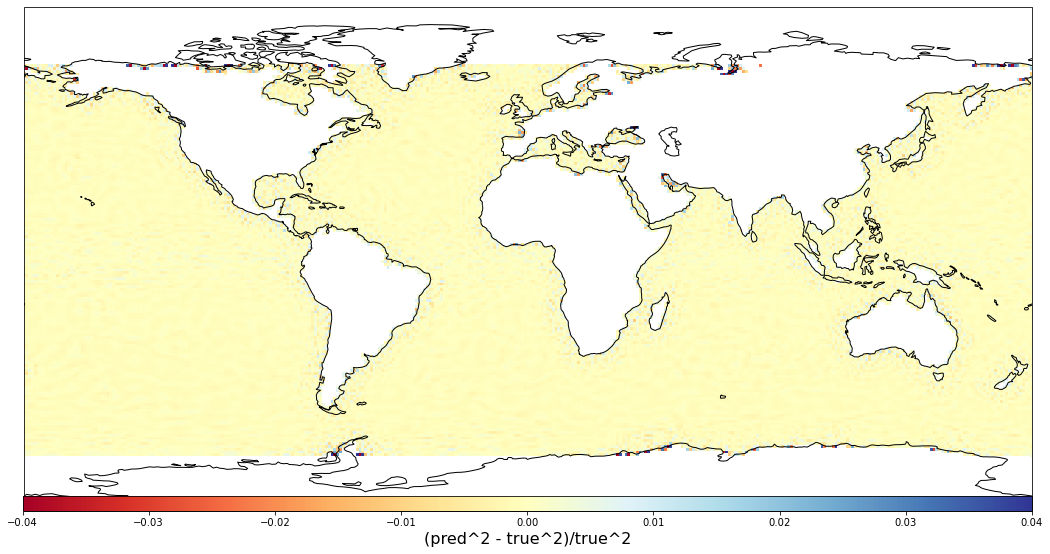

mean:  0.0013763343153090355
max:  0.09165906


In [339]:
importlib.reload(dsp)
lon = np.arange(-180, 180)
lat = np.arange(-80, 80)
lon2d, lat2d = np.meshgrid(lon, lat)
eps = (pred_sphere**2-true_sphere**2)/true_sphere**2
eps1 = (pred_sphere1**2-true_sphere**2)/true_sphere**2
eps2 = (pred_sphere2**2-true_sphere**2)/true_sphere**2
eps3 = (pred_sphere3**2-true_sphere3**2)/true_sphere3**2
eps4 = (pred_sphere4**2-true_sphere**2)/true_sphere**2
#eps3 = (pred_flat2**2-true_flat**2)/true_flat**2
eps5 = (pred_sphere5**2-true_sphere5**2)/true_sphere5**2
eps6 = (pred_sphere6**2-true_sphere6**2)/true_sphere6**2
eps7 = (pred_sphere7**2-true_sphere7**2)/true_sphere7**2


eps8 = (pred_sphere8**2-true_sphere8**2)/true_sphere8**2
#mse = (pred_flat-true_flat)**2
#mse1 = (pred_flat1-true_flat)**2
#mse2 = (pred_flat2-true_flat)**2
#dsp.plot_diff_globe((1/true_flat-1/pred_flat)*true_flat,(1/true_sph-1/pred_sph)*true_sph, lon2d, lat2d,vmin=-0.05,vmax=0.05,cmap="RdYlBu")
#print(np.mean(np.abs(reldiffUNET)))
#dsp.plot_diff_globe((1/true_flat-1/pred_flat)*true_flat,(1/true_flat-1/pred_flat)*true_flat, lon2d, lat2d,vmin=-0.02,vmax=0.02,cmap="RdYlBu")
#eps[160//2 + 10,:] = 1
mask = np.where(true_sphere==0,True,False)
dsp.plot_error_globe(np.ma.masked_array(eps2, mask), lon2d, lat2d,vmin=-0.04,vmax=0.04,cmap="RdYlBu",
                     cmap_title="(pred^2 - true^2)/true^2")
#print("mean UNET: ",np.count(np.nonzero(np.abs(np.nan_to_num(eps,posinf=0,neginf=0)))))

num_eps = np.ma.masked_array(eps2, mask)
print("mean: ",np.mean(np.abs(num_eps)[np.nonzero(num_eps)]))
print("max: ",np.max(np.abs(num_eps)))

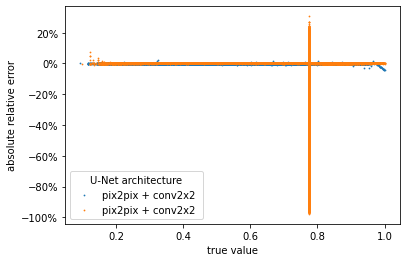

In [326]:
fig,ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
#ax.scatter(true_sphere[np.nonzero(true_sphere)],eps2[np.nonzero(true_sphere)], s=0.6,label="ronneberger")
ax.scatter(true_sphere[np.nonzero(true_sphere)],eps1[np.nonzero(true_sphere)], s=0.6,label="pix2pix + conv2x2")
ax.scatter(true_sphere8[np.nonzero(true_sphere8)]/np.max(true_sphere8[np.nonzero(true_sphere8)]),eps8[np.nonzero(true_sphere8)], s=0.6,label="pix2pix + conv2x2 ")
#ax.scatter(true_sphere[np.nonzero(true_sphere)],eps[np.nonzero(true_sphere)], s=0.6,label="pix2pix")
#ax.scatter(true_sphere[np.nonzero(true_sphere)],eps6[np.nonzero(true_sphere)], s=0.6,label="pix2pix pix2pix + conv2x2 (normalised outputs)")
#ax.scatter(true_sphere[np.nonzero(true_sphere)],eps7[np.nonzero(true_sphere)], s=0.6,label="pix2pix pix2pix + conv2x2 (normalised outputs)")
ax.set_ylabel("absolute relative error")
ax.set_xlabel("true value")
ax.legend(title="U-Net architecture")
#ax.set_title("error averaged over distance to coast intervals")

<class 'numpy.ndarray'>


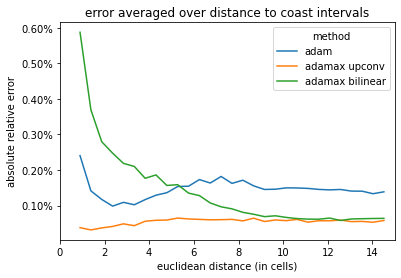

In [77]:
import matplotlib.ticker as mtick
eps_flat1 = eps2[8:-8,:]
eps_flat2 = eps3[8:-8,:]

n=30
ranges = np.linspace(0.9,15.,n)
means = np.zeros(n-1)
means1 = np.zeros(n-1)
means2 = np.zeros(n-1)
means3 = np.zeros(n-1)
print(type(dst))
for i in range(len(ranges[:-1])):
    means[i] = np.mean(np.abs(eps[np.nonzero((dst<ranges[i+1]) & (dst>ranges[i]))]))
    means1[i] = np.mean(np.abs(eps1[np.nonzero((dst<ranges[i+1]) & (dst>ranges[i]))]))
    means2[i] = np.mean(np.abs(eps2[np.nonzero((dst<ranges[i+1]) & (dst>ranges[i]))]))
    #means3[i] = np.mean(np.abs(eps_flat2[np.nonzero((dst<ranges[i+1]) & (dst>ranges[i]))]))
fig,ax = plt.subplots()
ax.plot(ranges[:-1],means,label="adam")
ax.plot(ranges[:-1],means1,label="adamax upconv")
ax.plot(ranges[:-1],means2,label="adamax bilinear")
#ax.plot(ranges[:-1],means3,label="adamax weighted")
ax.set_xlim(0.,15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
ax.set_ylabel("absolute relative error")
ax.set_xlabel("euclidean distance (in cells)")
ax.set_title("error averaged over distance to coast intervals")
ax.legend(title="method")

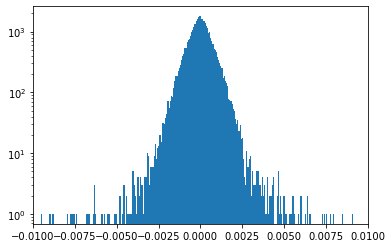

In [56]:
fig,ax = plt.subplots()
ax.hist(num_eps[np.nonzero(num_eps)],bins=1000)
ax.set_xlim(-0.01,0.01)
ax.set_yscale("log")

Text(0.5, 1.0, 'True value histogram')

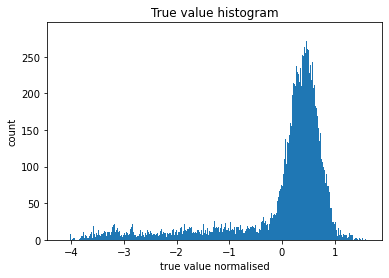

In [315]:
fig,ax = plt.subplots()
#print(np.count_nonzero(true_sphere))
ax.hist((true_sphere[np.nonzero(true_sphere)]-np.mean(
    true_sphere[np.nonzero(true_sphere)]))/np.std(true_sphere[np.nonzero(true_sphere)]),bins=1000)
ax.set_xlabel("true value normalised")
ax.set_ylabel("count")
ax.set_title("True value histogram")
#ax.set_xlim(-0.01,0.01)
#ax.set_yscale("log")

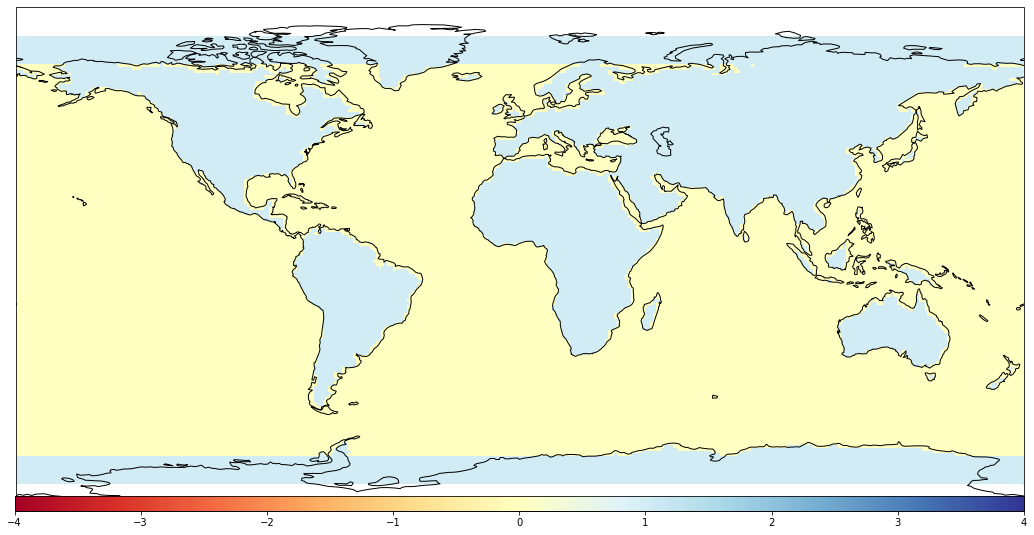

torch.Size([160, 340])


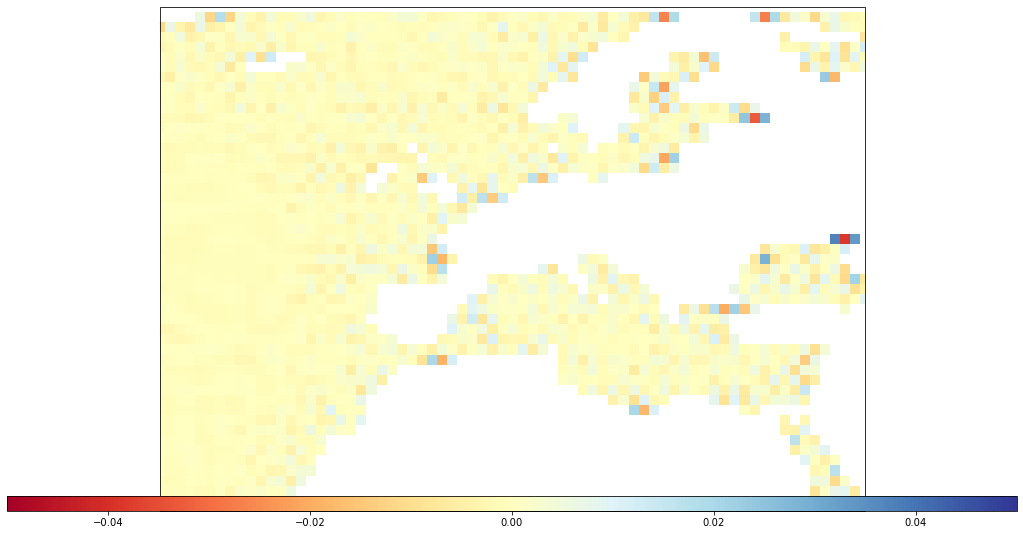

In [340]:
print(X[0,0,:,38:-38].shape)
dsp.plot_error_region(np.ma.masked_array(eps2, mask), 
                       lon2d, lat2d,region="europe",cmap="RdYlBu",vmin=-0.05,vmax=0.05)

<class 'numpy.ndarray'>


Text(0.5, 1.0, 'error averaged over distance to coast intervals')

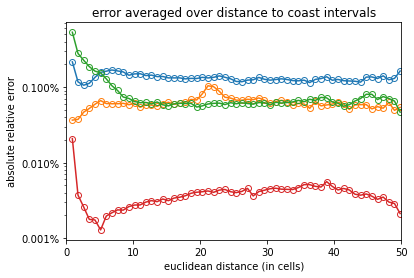

In [333]:
import matplotlib.ticker as mtick


n=60
ranges = np.linspace(0.9,np.max(dst),n)
means = np.zeros(n-1)
means1 = np.zeros(n-1)
means2 = np.zeros(n-1)
means3 = np.zeros(n-1)
print(type(dst))
for i in range(len(ranges[:-1])):
    means[i] = np.mean(np.abs(eps[np.nonzero((dst<ranges[i+1]) & (dst>ranges[i]))]))
    means1[i] = np.mean(np.abs(eps1[np.nonzero((dst<ranges[i+1]) & (dst>ranges[i]))]))
    means2[i] = np.mean(np.abs(eps2[np.nonzero((dst<ranges[i+1]) & (dst>ranges[i]))]))
    means3[i] = np.mean(np.abs(eps8[np.nonzero((dst<ranges[i+1]) & (dst>ranges[i]))]))
fig,ax = plt.subplots()
ax.semilogy(ranges[:-1],means,"o-",markerfacecolor='none',label="pix2pix",)
ax.semilogy(ranges[:-1],means1,"o-",markerfacecolor='none',label="pix2pix + 2x2conv")
ax.semilogy(ranges[:-1],means2,"o-",markerfacecolor='none',label="ronneberger")
ax.semilogy(ranges[:-1],means3,"o-",markerfacecolor='none',label="pix2pix5 + 2x2conv normalised")
ax.set_xlim(0.,50)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=3, symbol='%', is_latex=False))
ax.set_ylabel("absolute relative error")
ax.set_xlabel("euclidean distance (in cells)")
ax.set_title("error averaged over distance to coast intervals")

#ax.legend(title="U-Net architecture")

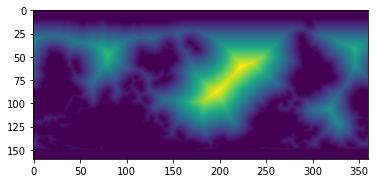

In [27]:
pad = 40
mask_pad = np.empty((160,360 + 2*pad),dtype=bool)

mask = np.where(true_sphere==0,True,False)
mask_pad[:,pad:-pad] = mask
mask_pad[:,:pad] = np.copy(mask_pad[:,-2*pad:-pad])
mask_pad[:,-pad:] = np.copy(mask_pad[:,pad:2*pad])


dst_pad = scm.distance_transform_bf(~mask_pad)
dst=dst_pad[:,pad:-pad]
plt.imshow(dst)

<class 'numpy.ndarray'>


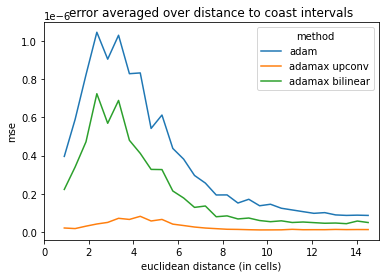

In [216]:
n=30
ranges = np.linspace(0.9,15.,n)
means = np.zeros(n-1)
means1 = np.zeros(n-1)
means2 = np.zeros(n-1)
print(type(dst))
for i in range(len(ranges[:-1])):
    means[i] = np.mean(np.abs(mse[np.nonzero((dst<ranges[i+1]) & (dst>ranges[i]))]))
    means1[i] = np.mean(np.abs(mse1[np.nonzero((dst<ranges[i+1]) & (dst>ranges[i]))]))
    means2[i] = np.mean(np.abs(mse2[np.nonzero((dst<ranges[i+1]) & (dst>ranges[i]))]))
fig,ax = plt.subplots()
ax.plot(ranges[:-1],means,label="adam")
ax.plot(ranges[:-1],means1,label="adamax upconv")
ax.plot(ranges[:-1],means2,label="adamax bilinear")
ax.set_xlim(0.,15)
#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
ax.set_ylabel("mse")
ax.set_xlabel("euclidean distance (in cells)")
ax.set_title("error averaged over distance to coast intervals")
ax.legend(title="method")

(array([6823., 4288., 3913., 3334., 3344., 2630., 2632., 1868., 1812.,
        1234., 1182.,  832.,  777.,  560.,  550.,  475.,  452.,  375.,
         321.,  125.]),
 array([ 1.        ,  3.48475837,  5.96951674,  8.45427511, 10.93903348,
        13.42379186, 15.90855023, 18.3933086 , 20.87806697, 23.36282534,
        25.84758371, 28.33234208, 30.81710045, 33.30185882, 35.7866172 ,
        38.27137557, 40.75613394, 43.24089231, 45.72565068, 48.21040905,
        50.69516742]),
 <BarContainer object of 20 artists>)

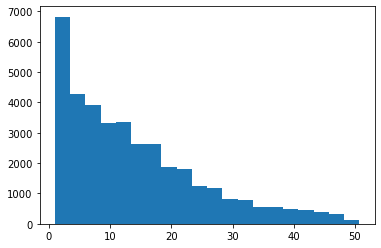

In [43]:
fig,ax = plt.subplots()
ax.hist(dst[np.nonzero(dst)],bins=20)
#ax.set_xlim(0,26)

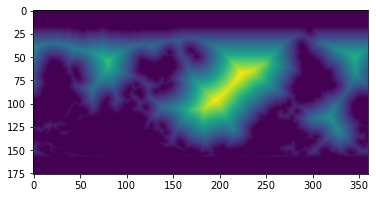

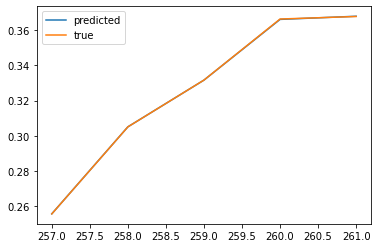

In [16]:
low = 257
high = 262
lat = 155
plt.plot(np.arange(low,high),pred_flat1[lat,low:high],label="predicted")
plt.plot(np.arange(low,high),true_flat[lat,low:high],label="true")
plt.legend()
plt.show()

In [ ]:
datadir = "learning_curve_3_6_7_8_9_normalised"
X = np.load("dataset/Dalyes.npy",allow_pickle=True)
#X = X[:,10:-10,40:-40]
print(X[0].shape)
D_lat = X[0][11:-10,:]
D_lon = X[1][10:-10,1:]

In [ ]:
from matplotlib.patches import Ellipse
nx, ny = (9, 12)
x = np.linspace(0, 159, nx,dtype=int)
y = np.linspace(0, 359, ny,dtype=int)
xv = np.repeat(x,len(y))
yv = np.tile(y,len(x))


ells = [Ellipse(xy=(j,i),
                width=D_lon[i,j]/20000*(1-mask[i,j]), height=D_lat[i,j]/20000*(1-mask[i,j])) for i,j in zip(xv,yv)]

fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
for e in ells:
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.8)
    #e.set_facecolor(np.random.rand(3))
ax.imshow(1-mask,cmap="gray")
ax.set_xlim(0, 360)
ax.set_ylim(0, 180)
plt.tight_layout()
plt.show()